<img src="https://upload.wikimedia.org/wikipedia/en/thumb/6/62/University_of_Sydney.svg/220px-University_of_Sydney.svg.png" style="float: left; margin: 20px; height: 130px">

# One-Shot Learning Face Recognition

_Author: Mill Liao_

In [177]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from scipy import spatial

from pca_plotter import PCAPlotter

%matplotlib inline

## 1. Load Data

In [118]:
data = np.load("olivetti_faces.npy")
target = np.load("olivetti_faces_target.npy")

index_train = random.sample(range(len(data)), int(len(data)*0.9))
index_test = list(set(list(range(len(data))))-set(index_train))

X_train, X_test = data[index_train], data[index_test]
y_train, y_test = target[index_train], target[index_test]
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (360, 64, 64)
y_train shape: (360,)
X_test shape: (40, 64, 64)
y_test shape: (40,)


In [119]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2])) 
print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train reshape: (360, 4096)
X_test reshape: (40, 4096)


## 2. EDA

In [167]:
def plot_triplet(triplet):
    plt.figure(figsize=(12,4))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        #img = np.reshape(triplet[0],(4096,))
        img = np.reshape(triplet[i], (64, 64))
        img = cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.xticks()
        plt.yticks()
    plt.show()

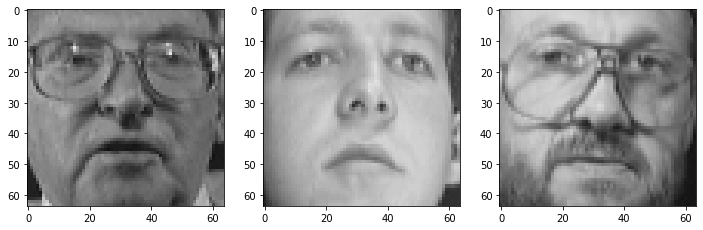

In [168]:
plot_triplet([X_train[0], X_train[1], X_train[2]])

## 3. A Batch of Triplets

In [143]:
def create_batch(batch_size):
    
    anchors = np.zeros((batch_size, X_train.shape[1]))
    positives = np.zeros((batch_size, X_train.shape[1]))
    negatives = np.zeros((batch_size, X_train.shape[1]))
    
    for i in range(0, batch_size):
        index = random.randint(0, X_train.shape[0] - 1)
        anc = X_train[index]
        y = y_train[index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))
        
        pos = X_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        neg = X_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        anchors[i] = anc
        positives[i] = pos
        negatives[i] = neg
        
    return [anchors, positives, negatives]

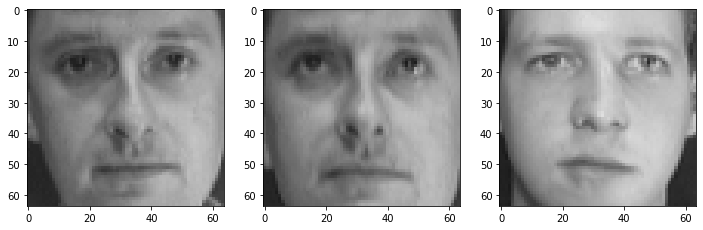

In [169]:
triplet = create_batch(1)
plot_triplet([triplet[0][0], triplet[1][0], triplet[2][0]])

## 4. Embedding Model

In [173]:
emb_dim = 64

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(4096,)),
    tf.keras.layers.Dense(emb_dim, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                262208    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
Total params: 266,368
Trainable params: 266,368
Non-trainable params: 0
_________________________________________________________________


In [174]:
example = X_train[0]
example_emb = embedding_model.predict(np.expand_dims(example, axis=0))[0]
print(example_emb)

[0.47597942 0.38112208 0.54883254 0.477641   0.3361009  0.47072515
 0.4186769  0.3842554  0.6441823  0.45505166 0.704779   0.6963288
 0.48484766 0.550585   0.5731832  0.41328153 0.49154997 0.527294
 0.51233053 0.40462875 0.608883   0.51348275 0.5033692  0.37447077
 0.30838054 0.63238394 0.43474102 0.6103897  0.35414898 0.6513006
 0.33719373 0.5285038  0.5885539  0.45937213 0.5208283  0.27420098
 0.41678527 0.5142021  0.3445838  0.50657576 0.391724   0.6612543
 0.41497582 0.4292984  0.4303077  0.6124066  0.4483907  0.45620942
 0.5355316  0.62021327 0.50901556 0.39213014 0.38787675 0.48034152
 0.6140564  0.5168123  0.32941487 0.44187114 0.6189306  0.37559566
 0.47274694 0.55399436 0.4165196  0.3609864 ]


## 5. Siamese Network

In [175]:
in_anc = tf.keras.layers.Input(shape=(4096,))
in_pos = tf.keras.layers.Input(shape=(4096,))
in_neg = tf.keras.layers.Input(shape=(4096,))

em_anc = embedding_model(in_anc)
em_pos = embedding_model(in_pos)
em_neg = embedding_model(in_neg)

out = tf.keras.layers.concatenate([em_anc, em_pos, em_neg], axis=1)

net = tf.keras.models.Model(
    [in_anc, in_pos, in_neg],
    out
)
net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64)           266368      input_1[0][0]                    
                                                                 input_2[0][0]                

## 6. Triplet Loss

In [176]:
def triplet_loss(alpha, emb_dim):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:, :emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:, 2*emb_dim:]
        dp = tf.reduce_mean(tf.square(tf.subtract(anc,pos)), axis=1)
        dn = tf.reduce_mean(tf.square(tf.subtract(anc,neg)), axis=1)
        return tf.maximum(tf.add(tf.subtract(dp,dn),alpha),0.)
    return loss

## 7. Data Generator

In [178]:
def data_generator(batch_size, emb_dim):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_dim))
        yield x, y

## 8. Model Training

In [184]:
batch_size = 10
epochs = 500
steps_per_epoch = int(X_train.shape[0]/batch_size)

net.compile(loss=triplet_loss(alpha=0.2, emb_dim=emb_dim), optimizer='adam')

/Users/john_stuart_mill/Desktop/MDS_USYD/DATA5703/Week3/pca_plotter.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/500
36/36 - 1s - loss: 0.0233
Epoch 2/500
36/36 - 0s - loss: 0.0232
Epoch 3/500
36/36 - 0s - loss: 0.0213
Epoch 4/500
36/36 - 0s - loss: 0.0236
Epoch 5/500
36/36 - 0s - loss: 0.0233
Epoch 6/500
36/36 - 0s - loss: 0.0169
Epoch 7/500
36/36 - 0s - loss: 0.0244
Epoch 8/500
36/36 - 0s - loss: 0.0221
Epoch 9/500
36/36 - 0s - loss: 0.0181
Epoch 10/500
36/36 - 0s - loss: 0.0164
Epoch 11/500
36/36 - 0s - loss: 0.0156
Epoch 12/500
36/36 - 0s - loss: 0.0197
Epoch 13/500
36/36 - 0s - loss: 0.0232
Epoch 14/500
36/36 - 0s - loss: 0.0210
Epoch 15/500
36/36 - 0s - loss: 0.0202
Epoch 16/500
36/36 - 0s - loss: 0.0217
Epoch 17/500
36/36 - 0s - loss: 0.0121
Epoch 18/500
36/36 - 0s - loss: 0.0156
Epoch 19/500
36/36 - 0s - loss: 0.0196
Epoch 20/500
36/36 - 0s - loss: 0.0185
Epoch 21/500
36/36 - 0s - loss: 0.0192
Epoch 22/500
36/36 - 0s - loss: 0.0208
Epoch 23/500
36/36 - 0s - loss: 0.0192
Epoch 24/500
36/36 - 0s - loss: 0.0191
Epoch 25/500
36/36 - 0s - loss: 0.0186
Epoch 26/500
36/36 - 0s - loss: 0.

Epoch 209/500
36/36 - 0s - loss: 0.0087
Epoch 210/500
36/36 - 0s - loss: 0.0118
Epoch 211/500
36/36 - 0s - loss: 0.0128
Epoch 212/500
36/36 - 0s - loss: 0.0145
Epoch 213/500
36/36 - 0s - loss: 0.0148
Epoch 214/500
36/36 - 0s - loss: 0.0097
Epoch 215/500
36/36 - 0s - loss: 0.0127
Epoch 216/500
36/36 - 0s - loss: 0.0125
Epoch 217/500
36/36 - 0s - loss: 0.0104
Epoch 218/500
36/36 - 0s - loss: 0.0127
Epoch 219/500
36/36 - 0s - loss: 0.0128
Epoch 220/500
36/36 - 0s - loss: 0.0098
Epoch 221/500
36/36 - 0s - loss: 0.0150
Epoch 222/500
36/36 - 0s - loss: 0.0137
Epoch 223/500
36/36 - 0s - loss: 0.0129
Epoch 224/500
36/36 - 0s - loss: 0.0100
Epoch 225/500
36/36 - 0s - loss: 0.0104
Epoch 226/500
36/36 - 0s - loss: 0.0108
Epoch 227/500
36/36 - 0s - loss: 0.0142
Epoch 228/500
36/36 - 0s - loss: 0.0157
Epoch 229/500
36/36 - 0s - loss: 0.0112
Epoch 230/500
36/36 - 0s - loss: 0.0103
Epoch 231/500
36/36 - 0s - loss: 0.0132
Epoch 232/500
36/36 - 0s - loss: 0.0102
Epoch 233/500
36/36 - 0s - loss: 0.0099


Epoch 414/500
36/36 - 0s - loss: 0.0095
Epoch 415/500
36/36 - 0s - loss: 0.0077
Epoch 416/500
36/36 - 0s - loss: 0.0080
Epoch 417/500
36/36 - 0s - loss: 0.0058
Epoch 418/500
36/36 - 0s - loss: 0.0081
Epoch 419/500
36/36 - 0s - loss: 0.0076
Epoch 420/500
36/36 - 0s - loss: 0.0101
Epoch 421/500
36/36 - 0s - loss: 0.0107
Epoch 422/500
36/36 - 0s - loss: 0.0114
Epoch 423/500
36/36 - 0s - loss: 0.0097
Epoch 424/500
36/36 - 0s - loss: 0.0081
Epoch 425/500
36/36 - 0s - loss: 0.0077
Epoch 426/500
36/36 - 0s - loss: 0.0056
Epoch 427/500
36/36 - 0s - loss: 0.0088
Epoch 428/500
36/36 - 0s - loss: 0.0096
Epoch 429/500
36/36 - 0s - loss: 0.0112
Epoch 430/500
36/36 - 0s - loss: 0.0061
Epoch 431/500
36/36 - 0s - loss: 0.0074
Epoch 432/500
36/36 - 0s - loss: 0.0079
Epoch 433/500
36/36 - 0s - loss: 0.0093
Epoch 434/500
36/36 - 0s - loss: 0.0084
Epoch 435/500
36/36 - 0s - loss: 0.0147
Epoch 436/500
36/36 - 0s - loss: 0.0121
Epoch 437/500
36/36 - 0s - loss: 0.0091
Epoch 438/500
36/36 - 0s - loss: 0.0084


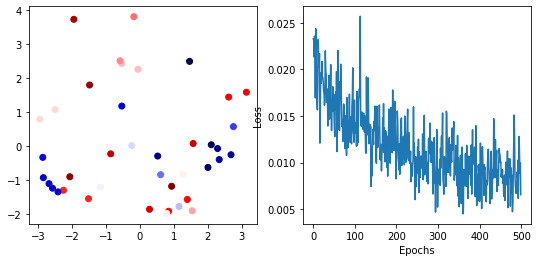

In [185]:
_ = net.fit(
    data_generator(batch_size, emb_dim),
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    verbose=2,
    callbacks=[
        PCAPlotter(plt, embedding_model, X_test, y_test)
    ]
)

## 9. Prediction

In [214]:
def cos_similarity(a,b):
    return 1 - spatial.distance.cosine(a, b)

In [213]:
batch = net.predict(create_batch(1000))
model_score = 0
for i in range(100):
    one_batch = batch[i]
    anchor, pos, neg = one_batch[:64].tolist(), one_batch[64:128].tolist(), one_batch[128:].tolist()
    pos_score, neg_score = cos_similarity(anchor, pos), cos_similarity(anchor, neg)
    if pos_score > neg_score:
        model_score = model_score + 1
        
print('Model Score:', model_score/100)

Model Score: 1.0
